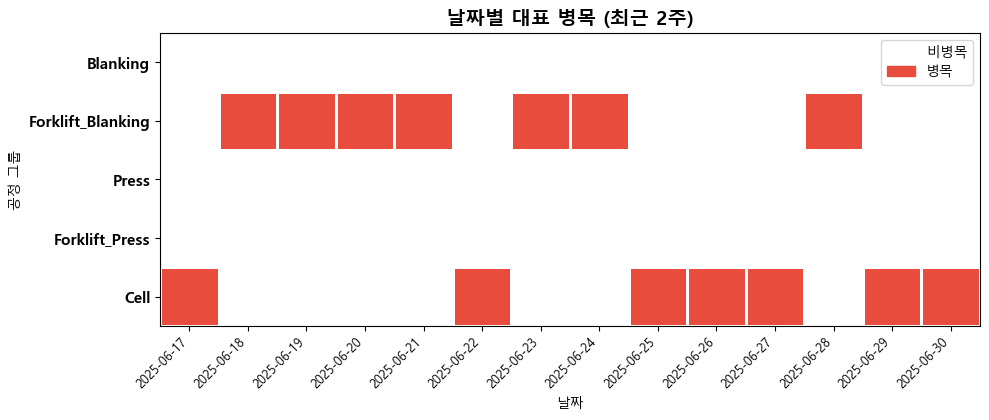

In [1]:
# -*- coding: utf-8 -*-
"""
날짜별 병목(ROW 단위 max Queue → 하루 대표 1개) 추출 후 타일 그래프 시각화
- 각 날짜별 병목은 하루 전체 데이터에서 'Queue 최댓값 빈도가 가장 많은 공정'으로 결정
- 표시 순서: Cell(=Warehouse) → Forklift_Press → Press → Forklift_Blanking → Blanking
- 최근 2주만 표시
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# =========================
# 설정
# =========================
CSV_PATH = "subset_20240101_20250630_fullcols.csv"

# 단계 색상: 0=비병목(흰색), 1=병목(빨강)
STAGE_COLORS = ["#ffffff", "#e74c3c"]
STAGE_LABELS = ["비병목", "병목"]

# colormap & boundary
cmap  = mpl.colors.ListedColormap(STAGE_COLORS)
bounds = [-0.5, 0.5, 1.5]
norm  = mpl.colors.BoundaryNorm(bounds, cmap.N)

# =========================
# 한글 폰트
# =========================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False
    cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fontManager.ttflist}
    for n in cand:
        if n in avail:
            mpl.rcParams["font.family"] = n
            return
set_korean_font()

# =========================
# 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if "queue" in c.lower()]
if not queue_cols:
    raise ValueError("Queue 관련 컬럼이 없습니다.")

# =========================
# 날짜별 병목 추출
# =========================
date_bneck = []
for d, g in df.groupby("_date"):
    row_bneck = g[queue_cols].astype(float).idxmax(axis=1)
    top = row_bneck.value_counts().idxmax()
    date_bneck.append((d, top))

date_bneck = pd.DataFrame(date_bneck, columns=["date", "bneck"])

# =========================
# 표시 그룹 (Warehouse → Cell)
# =========================
DISPLAY_ORDER = [
    ("Warehouse1_Queue", "Cell"),
    ("Forklift_Press_Queue", "Forklift_Press"),
    ("Press2_Queue", "Press"),
    ("Forklift_Blanking_Queue", "Forklift_Blanking"),
    ("Blanking_SKU1_Queue", "Blanking"),
]
PLOT_GROUPS = [show for _, show in DISPLAY_ORDER]
name_map = {src: show for src, show in DISPLAY_ORDER}

# =========================
# 최근 2주만 선택
# =========================
last_days = 14
date_bneck_recent = date_bneck.sort_values("date").tail(last_days)

dates = date_bneck_recent["date"].dt.strftime("%Y-%m-%d").tolist()
M, N = len(PLOT_GROUPS), len(dates)
mat = np.zeros((M, N))

for j, row in date_bneck_recent.iterrows():
    src = row["bneck"]
    if src in name_map:
        show = name_map[src]
        i = PLOT_GROUPS.index(show)
        mat[i, date_bneck_recent.index.get_loc(j)] = 1

# =========================
# 시각화
# =========================
fig, ax = plt.subplots(figsize=(max(10, 0.5*N), 4))

cmap  = mpl.colors.ListedColormap(STAGE_COLORS)
bounds = [-0.5, 0.5, 1.5]
norm  = mpl.colors.BoundaryNorm(bounds, cmap.N)

x_edges = np.arange(N+1); y_edges = np.arange(M+1)
quad = ax.pcolormesh(x_edges, y_edges, mat, cmap=cmap, norm=norm,
                     edgecolors="white", linewidth=0.8, shading="flat")
ax.set_aspect("equal")

# 라벨
ax.set_yticks(np.arange(M)+0.5)
ax.set_yticklabels(PLOT_GROUPS, fontsize=11, fontweight="bold")
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(dates, rotation=45, ha="right", fontsize=9)

# 범례
legend_handles = [Patch(color=STAGE_COLORS[i], label=STAGE_LABELS[i]) for i in range(len(STAGE_LABELS))]
ax.legend(handles=legend_handles, loc="upper right")

ax.set_title("날짜별 대표 병목 (최근 2주)", fontsize=14, fontweight="bold")
ax.set_xlabel("날짜")
ax.set_ylabel("공정 그룹")

plt.tight_layout()
plt.show()

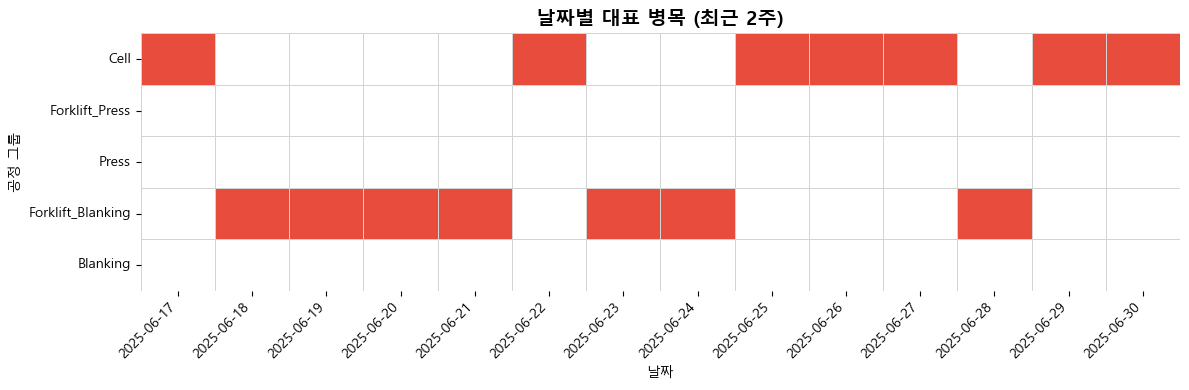

In [2]:
# -*- coding: utf-8 -*-
"""
날짜별 병목을 히트맵 스타일로 시각화
- 빨강: 병목 발생
- 흰색: 비병목
- 최근 2주만 표시
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==== 데이터 준비 (앞 코드에서 date_bneck_recent, PLOT_GROUPS 사용) ====
pivot = pd.DataFrame(0, index=PLOT_GROUPS, columns=dates)
for j, row in date_bneck_recent.iterrows():
    src = row["bneck"]
    if src in name_map:
        show = name_map[src]
        pivot.loc[show, row["date"].strftime("%Y-%m-%d")] = 1

# ==== 시각화 ====
plt.figure(figsize=(12,4))
sns.heatmap(pivot, cmap=["#ffffff","#e74c3c"], cbar=False,
            linewidths=0.5, linecolor="lightgrey", annot=False, fmt="")

plt.title("날짜별 대표 병목 (최근 2주)", fontsize=14, fontweight="bold")
plt.xlabel("날짜")
plt.ylabel("공정 그룹")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

[split] train=540일, test=7일

=== 병목 예측 결과 (마지막 1주 hold-out) ===
Accuracy: 1.0
                         precision    recall  f1-score   support

Forklift_Blanking_Queue       1.00      1.00      1.00         2
       Warehouse1_Queue       1.00      1.00      1.00         5

               accuracy                           1.00         7
              macro avg       1.00      1.00      1.00         7
           weighted avg       1.00      1.00      1.00         7


=== 일 단위 비교 (최근 1주) ===
                         true_bneck               pred_bneck  correct
_date                                                                
2025-06-24  Forklift_Blanking_Queue  Forklift_Blanking_Queue     True
2025-06-25         Warehouse1_Queue         Warehouse1_Queue     True
2025-06-26         Warehouse1_Queue         Warehouse1_Queue     True
2025-06-27         Warehouse1_Queue         Warehouse1_Queue     True
2025-06-28  Forklift_Blanking_Queue  Forklift_Blanking_Queue     True
2025-06-29    

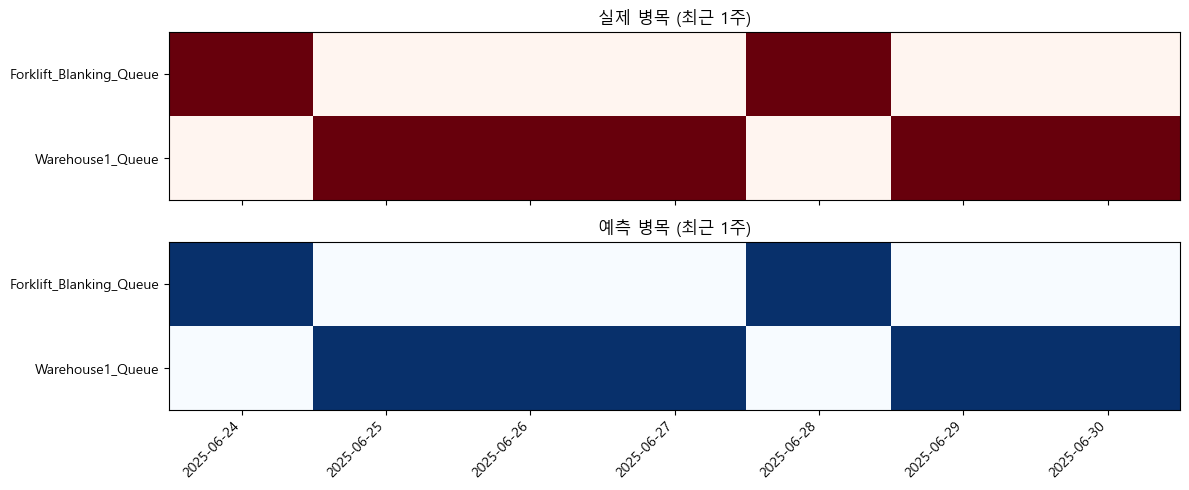

In [3]:
# ============================================
# 5) 날짜 단위 병목 예측 (마지막 1주 hold-out)
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 날짜 생성 (이미 df는 위 셀에서 로드됨)
df_seq = df.sort_values("Time_Now").reset_index(drop=True).copy()
df_seq["_date"] = pd.to_datetime(df_seq["Time_Now"]).dt.floor("D")

# 행별 병목 (_bneck)
Q = df_seq[[c for c in df_seq.columns if c.endswith("_Queue")]].apply(pd.to_numeric, errors="coerce")
df_seq["_bneck"] = Q.idxmax(axis=1)

# -----------------------------
# train/test 분할: 마지막 7일 test
# -----------------------------
all_dates = sorted(df_seq["_date"].unique())
train_dates = all_dates[:-7]
test_dates  = all_dates[-7:]

train_df = df_seq[df_seq["_date"].isin(train_dates)].copy()
test_df  = df_seq[df_seq["_date"].isin(test_dates)].copy()

print(f"[split] train={len(train_dates)}일, test={len(test_dates)}일")

# -----------------------------
# 피처(X), 라벨(y)
# -----------------------------
x_cols = [
    c for c in df_seq.columns
    if (not c.endswith("_Queue")) and (c not in ["_bneck","Time_Now","_date"])
    and (not c.startswith("c_Cell"))
]
X_train = train_df[x_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train = train_df["_bneck"].astype(str)

X_test = test_df[x_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
y_test = test_df["_bneck"].astype(str)

# -----------------------------
# RandomForest 학습 & 예측
# -----------------------------
clf = RandomForestClassifier(
    n_estimators=120, max_depth=15, n_jobs=-1,
    random_state=42, class_weight="balanced"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("\n=== 병목 예측 결과 (마지막 1주 hold-out) ===")
print("Accuracy:", round(acc,4))
print(classification_report(y_test, y_pred, zero_division=0))

# -----------------------------
# 날짜 단위 집계 (하루 대표 병목 = 최빈값)
# -----------------------------
true_daily = test_df.groupby("_date")["_bneck"].agg(lambda x: x.mode().iloc[0])
pred_daily = pd.Series(y_pred, index=test_df.index).groupby(test_df["_date"]).agg(lambda x: x.mode().iloc[0])

compare = pd.DataFrame({
    "true_bneck": true_daily,
    "pred_bneck": pred_daily
})
compare["correct"] = compare["true_bneck"] == compare["pred_bneck"]
print("\n=== 일 단위 비교 (최근 1주) ===")
print(compare)

# -----------------------------
# Heatmap 시각화 (위=실제, 아래=예측)
# -----------------------------
dates = compare.index.strftime("%Y-%m-%d").tolist()
groups = sorted(set(compare["true_bneck"]) | set(compare["pred_bneck"]))

mat_true = np.zeros((len(groups), len(dates)))
mat_pred = np.zeros((len(groups), len(dates)))

for j, d in enumerate(compare.index):
    t, p = compare.loc[d, "true_bneck"], compare.loc[d, "pred_bneck"]
    mat_true[groups.index(t), j] = 1
    mat_pred[groups.index(p), j] = 1

fig, axes = plt.subplots(2, 1, figsize=(12,5), sharex=True)

axes[0].imshow(mat_true, aspect="auto", cmap="Reds", interpolation="nearest")
axes[0].set_yticks(np.arange(len(groups)))
axes[0].set_yticklabels(groups)
axes[0].set_title("실제 병목 (최근 1주)")

axes[1].imshow(mat_pred, aspect="auto", cmap="Blues", interpolation="nearest")
axes[1].set_yticks(np.arange(len(groups)))
axes[1].set_yticklabels(groups)
axes[1].set_title("예측 병목 (최근 1주)")

axes[1].set_xticks(np.arange(len(dates)))
axes[1].set_xticklabels(dates, rotation=45, ha="right")

plt.tight_layout()
plt.show()

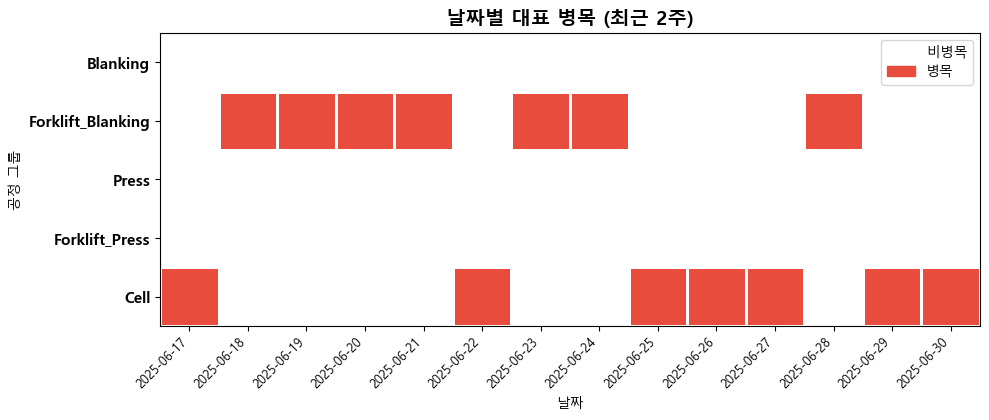


[INFO] 전체 데이터에서 가장 많이 발생한 병목 Queue = Warehouse1_Queue
[INFO] 병목 Cell = Cell1

[최근 2주간 Cell×SKU 생산량 합계]
 SKU           1       2       3      4
Cell                                  
c_Cell1  215355  169517       0  61910
c_Cell2       0   44354       0  68859
c_Cell3       0   16635   63984      0
c_Cell4       0       0  159194  96213


In [4]:
# -*- coding: utf-8 -*-
"""
[1] 날짜별 병목 (최근 2주) 타일 시각화
[2] 병목 Cell ↔ SKU 분포 분석 (밸런스 확인)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# =========================
# 설정
# =========================
CSV_PATH = "subset_20240101_20250630_fullcols.csv"

# 단계 색상: 0=비병목(흰색), 1=병목(빨강)
STAGE_COLORS = ["#ffffff", "#e74c3c"]
STAGE_LABELS = ["비병목", "병목"]

# colormap & boundary
cmap  = mpl.colors.ListedColormap(STAGE_COLORS)
bounds = [-0.5, 0.5, 1.5]
norm  = mpl.colors.BoundaryNorm(bounds, cmap.N)

# =========================
# 한글 폰트
# =========================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False
    cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fontManager.ttflist}
    for n in cand:
        if n in avail:
            mpl.rcParams["font.family"] = n
            return
set_korean_font()

# =========================
# 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if "queue" in c.lower()]
if not queue_cols:
    raise ValueError("Queue 관련 컬럼이 없습니다.")

# =========================
# 날짜별 병목 추출
# =========================
date_bneck = []
for d, g in df.groupby("_date"):
    row_bneck = g[queue_cols].astype(float).idxmax(axis=1)
    top = row_bneck.value_counts().idxmax()
    date_bneck.append((d, top))

date_bneck = pd.DataFrame(date_bneck, columns=["date", "bneck"])

# =========================
# 표시 그룹 (Warehouse → Cell)
# =========================
DISPLAY_ORDER = [
    ("Warehouse1_Queue", "Cell"),
    ("Forklift_Press_Queue", "Forklift_Press"),
    ("Press2_Queue", "Press"),
    ("Forklift_Blanking_Queue", "Forklift_Blanking"),
    ("Blanking_SKU1_Queue", "Blanking"),
]
PLOT_GROUPS = [show for _, show in DISPLAY_ORDER]
name_map = {src: show for src, show in DISPLAY_ORDER}

# =========================
# 최근 2주만 선택
# =========================
last_days = 14
date_bneck_recent = date_bneck.sort_values("date").tail(last_days)

dates = date_bneck_recent["date"].dt.strftime("%Y-%m-%d").tolist()
M, N = len(PLOT_GROUPS), len(dates)
mat = np.zeros((M, N))

for j, row in date_bneck_recent.iterrows():
    src = row["bneck"]
    if src in name_map:
        show = name_map[src]
        i = PLOT_GROUPS.index(show)
        mat[i, date_bneck_recent.index.get_loc(j)] = 1

# =========================
# [1] 시각화 (최근 2주 타일)
# =========================
fig, ax = plt.subplots(figsize=(max(10, 0.5*N), 4))

quad = ax.pcolormesh(
    np.arange(N+1), np.arange(M+1), mat,
    cmap=cmap, norm=norm, edgecolors="white", linewidth=0.8, shading="flat"
)
ax.set_aspect("equal")

ax.set_yticks(np.arange(M)+0.5)
ax.set_yticklabels(PLOT_GROUPS, fontsize=11, fontweight="bold")
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(dates, rotation=45, ha="right", fontsize=9)

legend_handles = [Patch(color=STAGE_COLORS[i], label=STAGE_LABELS[i]) for i in range(len(STAGE_LABELS))]
ax.legend(handles=legend_handles, loc="upper right")

ax.set_title("날짜별 대표 병목 (최근 2주)", fontsize=14, fontweight="bold")
ax.set_xlabel("날짜"); ax.set_ylabel("공정 그룹")

plt.tight_layout(); plt.show()


# =====================================================
# [2] 병목 Cell ↔ SKU 분포 분석
# =====================================================
cell_sku_cols = [c for c in df.columns if c.startswith("c_Cell")]

cell_sku_map = {
    "Cell1": [1, 2, 4],
    "Cell2": [2, 4],
    "Cell3": [2, 3],
    "Cell4": [3, 4],
}

# 최근 병목 top1 확인
row_bneck = df[queue_cols].astype(float).idxmax(axis=1)
top_bneck = row_bneck.value_counts().idxmax()
print(f"\n[INFO] 전체 데이터에서 가장 많이 발생한 병목 Queue = {top_bneck}")

if "Warehouse1_Queue" in top_bneck:   bneck_cell = "Cell1"
elif "Warehouse2_Queue" in top_bneck: bneck_cell = "Cell2"
elif "Warehouse3_Queue" in top_bneck: bneck_cell = "Cell3"
elif "Warehouse4_Queue" in top_bneck: bneck_cell = "Cell4"
else: bneck_cell = None

print(f"[INFO] 병목 Cell = {bneck_cell}")

# 최근 14일 데이터 기준 SKU 합계
df_recent = df[df["_date"] >= df["_date"].max() - pd.Timedelta(days=14)]
pivot = df_recent[cell_sku_cols].sum().reset_index()
pivot.columns = ["col", "value"]
pivot["Cell"] = pivot["col"].str.extract(r"(c_Cell\d+)")
pivot["SKU"]  = pivot["col"].str.extract(r"SKU(\d+)")

cell_sku_pivot = pivot.pivot_table(index="Cell", columns="SKU", values="value", aggfunc="sum").fillna(0)
print("\n[최근 2주간 Cell×SKU 생산량 합계]\n", cell_sku_pivot)

# 병목 Cell pie chart
if bneck_cell and bneck_cell in cell_sku_pivot.index:
    sku_dist = cell_sku_pivot.loc[bneck_cell]
    if sku_dist.sum() > 0:
        sku_dist.plot(kind="pie", autopct="%.1f%%", figsize=(5,5))
        plt.title(f"{bneck_cell} SKU 분포 (최근 2주)", fontsize=13)
        plt.ylabel("")
        plt.show()
    else:
        print(f"[경고] {bneck_cell}에 SKU 데이터가 없어 Pie chart를 그릴 수 없습니다.")

In [5]:
# -*- coding: utf-8 -*-
"""
병목 Cell 발생 시 SKU 분산 시뮬레이션
- 병목 = 전체 Queue 중 top1
- Cell별 SKU 생산량을 기반으로, 병목 Cell의 SKU를 다른 Cell로 재분배
"""

import pandas as pd
import numpy as np

# =====================
# 예시 데이터 (최근 2주 합계 pivot)
# =====================
cell_sku_pivot = pd.DataFrame({
    1: {"c_Cell1": 215355, "c_Cell2": 0, "c_Cell3": 0, "c_Cell4": 0},
    2: {"c_Cell1": 169517, "c_Cell2": 44354, "c_Cell3": 16635, "c_Cell4": 0},
    3: {"c_Cell1": 0, "c_Cell2": 0, "c_Cell3": 63984, "c_Cell4": 159194},
    4: {"c_Cell1": 61910, "c_Cell2": 68859, "c_Cell3": 0, "c_Cell4": 96213},
}).fillna(0).astype(int)

print("[최근 2주간 Cell×SKU 생산량 합계]")
print(cell_sku_pivot)

# =====================
# Cell ↔ SKU 매핑
# =====================
cell_sku_map = {
    "c_Cell1": [1, 2, 4],
    "c_Cell2": [2, 4],
    "c_Cell3": [2, 3],
    "c_Cell4": [3, 4],
}

# =====================
# 병목 Cell 지정 (예: 최근 Top1 = Cell1)
# =====================
bneck_cell = "c_Cell1"
print(f"\n[INFO] 최근 가장 많이 병목된 Cell = {bneck_cell}")

# =====================
# 병목 Cell → SKU별 비율
# =====================
bneck_skus = cell_sku_pivot.loc[bneck_cell]
total_bneck = bneck_skus.sum()

if total_bneck == 0:
    print("[경고] 병목 Cell에 SKU 데이터가 없습니다.")
else:
    sku_ratios = (bneck_skus / total_bneck).round(3)
    print("\n[병목 Cell SKU 분포 비율]")
    print(sku_ratios)

    # =====================
    # 분산 시뮬레이션
    # =====================
    redistributed = cell_sku_pivot.copy()

    for sku, ratio in sku_ratios.items():
        if ratio == 0:
            continue
        # 이 SKU를 처리할 수 있는 다른 Cell 후보
        eligible_cells = [c for c, skus in cell_sku_map.items() if (sku in skus and c != bneck_cell)]
        if not eligible_cells:
            continue
        # 병목 Cell에서 해당 SKU 물량
        qty = bneck_skus[sku]
        share = qty // len(eligible_cells)  # 균등 분배 (단순화)

        # 원래 병목 Cell에서 빼고
        redistributed.loc[bneck_cell, sku] -= qty
        # 다른 Cell에 나눠줌
        for c in eligible_cells:
            redistributed.loc[c, sku] += share

    print("\n[재분배 후 Cell×SKU 생산량]")
    print(redistributed)

    # =====================
    # 비교용 차이
    # =====================
    diff = redistributed - cell_sku_pivot
    print("\n[재분배 변화량]")
    print(diff)

[최근 2주간 Cell×SKU 생산량 합계]
              1       2       3      4
c_Cell1  215355  169517       0  61910
c_Cell2       0   44354       0  68859
c_Cell3       0   16635   63984      0
c_Cell4       0       0  159194  96213

[INFO] 최근 가장 많이 병목된 Cell = c_Cell1

[병목 Cell SKU 분포 비율]
1    0.482
2    0.379
3    0.000
4    0.139
Name: c_Cell1, dtype: float64

[재분배 후 Cell×SKU 생산량]
              1       2       3       4
c_Cell1  215355       0       0       0
c_Cell2       0  129112       0   99814
c_Cell3       0  101393   63984       0
c_Cell4       0       0  159194  127168

[재분배 변화량]
         1       2  3      4
c_Cell1  0 -169517  0 -61910
c_Cell2  0   84758  0  30955
c_Cell3  0   84758  0      0
c_Cell4  0       0  0  30955


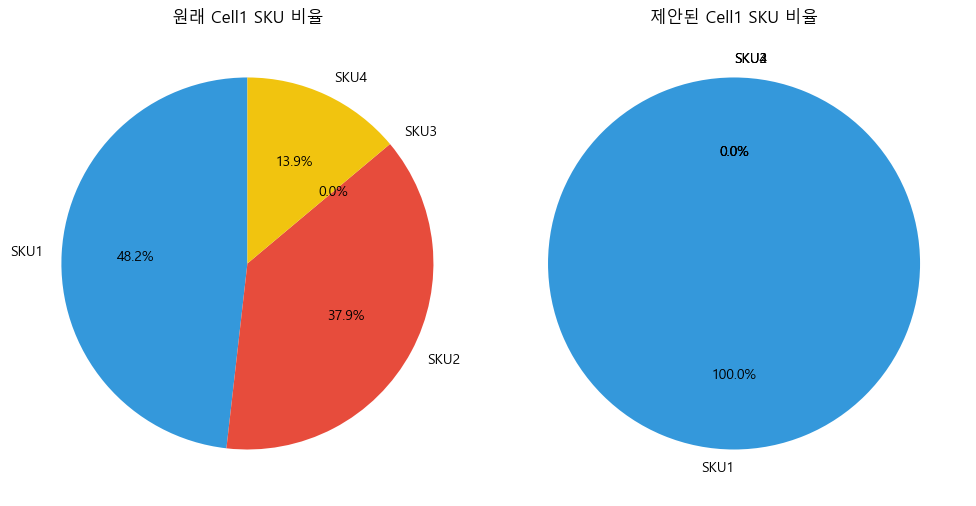

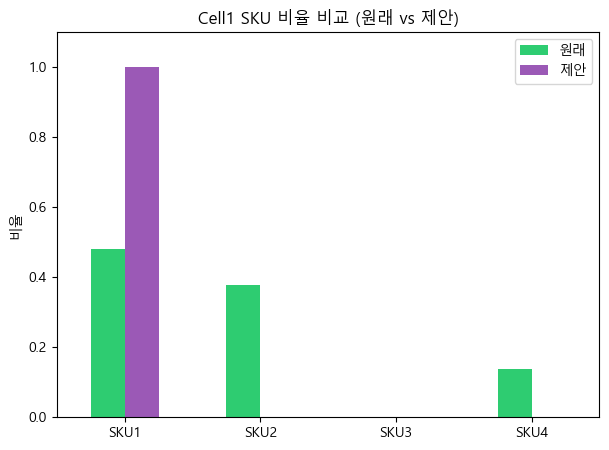

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# ==========================
# 원래 Cell1 비율 (최근 2주)
# ==========================
orig_ratio = pd.Series({
    "SKU1": 0.482,
    "SKU2": 0.379,
    "SKU3": 0.000,
    "SKU4": 0.139
})

# ==========================
# 제안 비율 (분배 반영 후)
# ==========================
# - Cell1은 SKU1 전담
# - SKU2는 Cell2/Cell3로 균등 분배 → Cell1=0%
# - SKU4는 Cell2/Cell4로 균등 분배 → Cell1=0%
# - SKU3는 원래도 없음
new_ratio = pd.Series({
    "SKU1": 1.000,
    "SKU2": 0.000,
    "SKU3": 0.000,
    "SKU4": 0.000
})

# ==========================
# 시각화 (파이 + 막대)
# ==========================
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# --- 파이차트 ---
axes[0].pie(orig_ratio, labels=orig_ratio.index, autopct="%.1f%%", 
            startangle=90, colors=["#3498db","#e74c3c","#95a5a6","#f1c40f"])
axes[0].set_title("원래 Cell1 SKU 비율")

axes[1].pie(new_ratio, labels=new_ratio.index, autopct="%.1f%%", 
            startangle=90, colors=["#3498db","#e74c3c","#95a5a6","#f1c40f"])
axes[1].set_title("제안된 Cell1 SKU 비율")

plt.tight_layout()
plt.show()

# --- 막대그래프 비교 ---
comp_df = pd.DataFrame({"원래": orig_ratio, "제안": new_ratio})
comp_df.plot(kind="bar", figsize=(7,5), color=["#2ecc71","#9b59b6"])
plt.title("Cell1 SKU 비율 비교 (원래 vs 제안)")
plt.ylabel("비율")
plt.xticks(rotation=0)
plt.ylim(0,1.1)
plt.show()

[재분배 후 Cell×SKU 비율]
       SKU1      SKU2      SKU3      SKU4
Cell1   1.0  0.000000  0.000000  0.000000
Cell2   0.0  0.563990  0.000000  0.436010
Cell3   0.0  0.613102  0.386898  0.000000
Cell4   0.0  0.000000  0.555919  0.444081


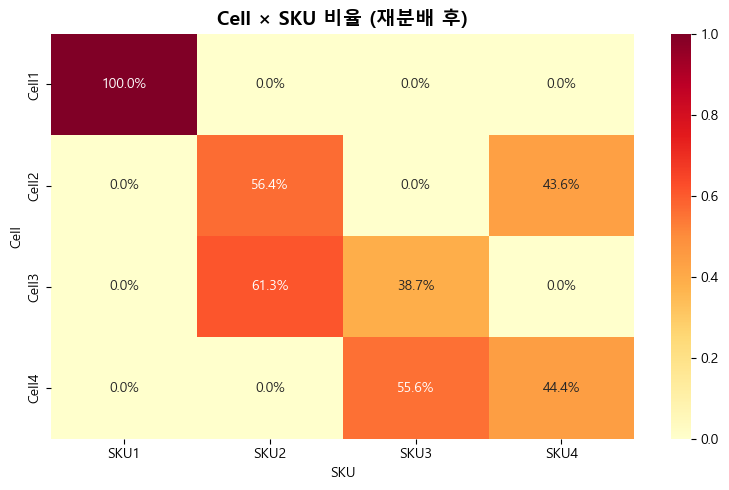

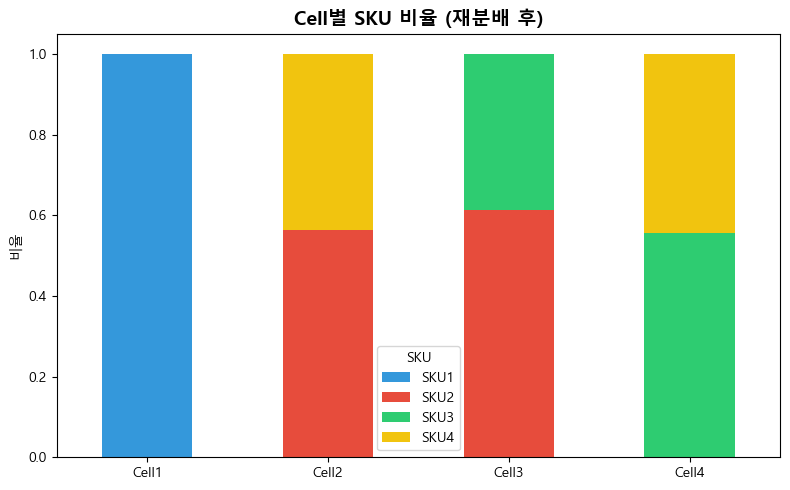

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================
# (예시) 재분배 후 Cell×SKU 생산량 (합계)
# ==========================
data = {
    "SKU1": [215355, 0, 0, 0],
    "SKU2": [0, 129112, 101393, 0],
    "SKU3": [0, 0, 63984, 159194],
    "SKU4": [0, 99814, 0, 127168],
}
cell_sku_df = pd.DataFrame(data, index=["Cell1","Cell2","Cell3","Cell4"])

# 비율화 (각 Cell row 합으로 나눔)
cell_sku_ratio = cell_sku_df.div(cell_sku_df.sum(axis=1), axis=0).fillna(0)

print("[재분배 후 Cell×SKU 비율]")
print(cell_sku_ratio)

# ==========================
# 1) 히트맵 (Cell × SKU)
# ==========================
plt.figure(figsize=(8,5))
sns.heatmap(cell_sku_ratio, annot=True, cmap="YlOrRd", fmt=".1%", cbar=True)
plt.title("Cell × SKU 비율 (재분배 후)", fontsize=14, fontweight="bold")
plt.xlabel("SKU")
plt.ylabel("Cell")
plt.tight_layout()
plt.show()

# ==========================
# 2) Stacked Bar Chart
# ==========================
cell_sku_ratio.plot(kind="bar", stacked=True, figsize=(8,5),
                    color=["#3498db","#e74c3c","#2ecc71","#f1c40f"])
plt.title("Cell별 SKU 비율 (재분배 후)", fontsize=14, fontweight="bold")
plt.ylabel("비율")
plt.xticks(rotation=0)
plt.legend(title="SKU")
plt.tight_layout()
plt.show()